In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# ----------------------------
# 1. Load & Inspect Data
# ----------------------------
# Reference: Ho et al. (2014) - HarvardX-MITx dataset paper
df = pd.read_csv("/Users/rekha/Documents/Thesis - 2024/Dataset/dataverse_files/HXPC13_DI_v3_11-13-2019.csv")

# Filter to key variables from documentation
cols = ['userid_DI', 'course_id', 'registered', 'viewed', 'explored', 'certified', 
        'final_cc_cname_DI', 'LoE_DI', 'YoB', 'gender', 'grade', 'start_time_DI',
        'last_event_DI', 'nevents', 'ndays_act', 'nplay_video', 'nchapters', 
        'nforum_posts']

df = df[cols]
print(df.head(3))

        userid_DI                   course_id  registered  viewed  explored  \
0  MHxPC130442623  HarvardX/CB22x/2013_Spring           1       0         0   
1  MHxPC130275857  HarvardX/CB22x/2013_Spring           1       0         0   
2  MHxPC130539455  HarvardX/CB22x/2013_Spring           1       1         0   

   certified final_cc_cname_DI LoE_DI  YoB gender grade start_time_DI  \
0          0     United States    NaN  NaN    NaN     0      12/19/12   
1          0     United States    NaN  NaN    NaN     0        2/8/13   
2          0            France    NaN  NaN    NaN     0        1/1/13   

  last_event_DI  nevents  ndays_act  nplay_video  nchapters  nforum_posts  
0      11/17/13      NaN        9.0          NaN        NaN             0  
1      11/17/13      NaN       16.0          NaN        NaN             0  
2       5/14/13     42.0        6.0          NaN        3.0             0  


Missing values before handling:


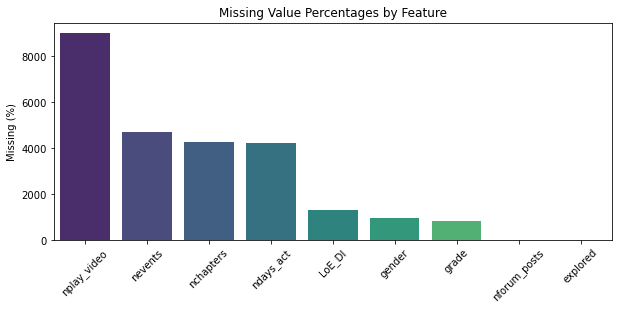

In [3]:
# ----------------------------
# 2. Handle Missing Data
# ----------------------------
# Reference: García-Laencina et al. (2010) - Missing data strategies in education

# Convert to numeric and handle empty strings
for col in ['nplay_video', 'nchapters', 'nforum_posts', 'nevents', 'ndays_act', 'grade']:
    df[col] = pd.to_numeric(df[col], errors = 'coerce')
    
# Calculate missing percentages
print("Missing values before handling:")
#print(df[['nevents', 'ndays_act', 'grade', 'nforum_posts', 'LoE_DI', 'gender', 'nplay_video', 'nchapters', 'explored']].isnull().sum())

missing = (df[['nevents', 'ndays_act', 'grade', 'nforum_posts', 'LoE_DI', 'gender', 'nplay_video', 'nchapters', 'explored']].isnull().sum().sort_values(ascending=False) / len(df)) * 100

# Visualize missingness (Reference: Wickham, 2016 - Visualization for analysis)
plt.figure(figsize=(10,4))
sns.barplot(x=missing.index, y=missing*100, palette="viridis")
plt.title("Missing Value Percentages by Feature")
plt.ylabel("Missing (%)")
plt.xticks(rotation=45)
plt.show()

In [4]:
# ----------------------------
# 3. Structural Missingness Handling
# ----------------------------
# Reference: Khalil & Ebner (2017) - MOOC engagement patterns

# Flag non-engaged learners before imputation
df['no_video_interaction'] = df['nplay_video'].isnull().astype(int)
df['no_activity'] = (df['nevents'].isnull() | df['ndays_act'].isnull() | df['nchapters'].isnull()).astype(int)

# Zero-imputation for structural non-engagement (Reference: Ho et al., 2014)
high_missing_cols = ['nplay_video', 'nevents', 'nchapters', 'ndays_act']
df[high_missing_cols] = df[high_missing_cols].fillna(0)  # Structural non-engagement

# Handle grade (critical outcome variable)
df['grade'] = df['grade'].fillna(0)  # 0 = no credit earned

In [5]:
# ----------------------------
# 4. Missing Data Imputation
# ----------------------------
# Reference: García-Laencina et al. (2010) - Missing data strategies in education

# Median imputation for numerical features (Reference: Han et al., 2011)
num_cols = ['nevents', 'ndays_act', 'grade', 'nforum_posts']
num_imputer = SimpleImputer(strategy='median')
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# Mode imputation for categoricals (Reference: Al-Shabandar et al., 2018)
cat_cols = ['LoE_DI', 'gender']
cat_imputer = SimpleImputer(strategy='most_frequent')
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])


Missing values after handling:


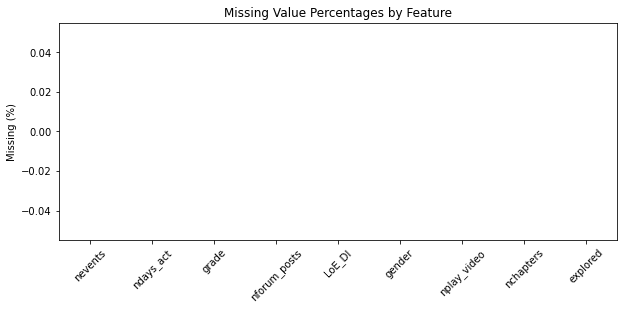


Non-engagement flag distribution:
Users with no video interaction: 90.16%
Users with no activity: 62.04%


In [6]:
# ----------------------------
# 5. Post-Imputation Validation
# ----------------------------
# Reference: Gardner & Brooks (2018) - MOOC data validation
print("\nMissing values after handling:")
#print(df[['nevents', 'ndays_act', 'grade', 'nforum_posts', 'LoE_DI', 'gender', 'nplay_video', 'nchapters']].isnull().sum())

missing = (df[['nevents', 'ndays_act', 'grade', 'nforum_posts', 'LoE_DI', 'gender', 'nplay_video', 'nchapters', 'explored']].isnull().sum().sort_values(ascending=False) / len(df)) * 100

plt.figure(figsize=(10,4))
sns.barplot(x=missing.index, y=missing*100, palette="viridis")
plt.title("Missing Value Percentages by Feature")
plt.ylabel("Missing (%)")
plt.xticks(rotation=45)
plt.show()

print("\nNon-engagement flag distribution:")
print(f"Users with no video interaction: {df['no_video_interaction'].mean()*100:.2f}%")
print(f"Users with no activity: {df['no_activity'].mean()*100:.2f}%")

In [7]:
# ----------------------------
# 6. Feature Engineering
# ----------------------------
# Reference: Boroujeni & Dillenbourg (2019) - Temporal engagement metrics

# Laplace smoothing to handle zero-inflation (Reference: Chen & Goodman, 1999)
df['engagement_intensity'] = (df['nevents'] + 1) / (df['ndays_act'] + 2)

# Knowledge check ratio (chapters completed vs videos watched)
df['quiz_to_video_ratio'] = (df['nchapters'] + 1) / (df['nplay_video'] + 2)

# Temporal features (Reference: Peach et al., 2019)
df['start_time_DI'] = pd.to_datetime(df['start_time_DI'])
df['last_event_DI'] = pd.to_datetime(df['last_event_DI'])
df['learning_duration'] = (df['last_event_DI'] - df['start_time_DI']).dt.days + 1

#df['learning_duration'] = (df['last_event_DI'] - df['start_time_DI']).dt.days

# Replace NaN and inf for 'learning_duration' as 0
df['learning_duration'] = df['learning_duration'].fillna(0)  
df['learning_duration'] = df['learning_duration'].replace([np.inf, -np.inf], 0)  
df['learning_duration'] = df['learning_duration'].astype(int)  

In [8]:
# ----------------------------
# 7. Normalization
# ----------------------------
# Reference: Han et al. (2011) - Data preprocessing for clustering
# Backup raw values before normalization
df['nevents_raw'] = df['nevents'].copy()

scaler = StandardScaler()
numeric_features = ['nevents', 'ndays_act', 'nplay_video', 'nforum_posts',
                   'nchapters', 'engagement_intensity', 
                   'quiz_to_video_ratio']

df[numeric_features] = scaler.fit_transform(df[numeric_features])

print("\nSample processed data:")
print(df[numeric_features + ['grade', 'no_activity']].head(3))


Sample processed data:
    nevents  ndays_act  nplay_video  nforum_posts  nchapters  \
0 -0.177161   0.836941    -0.085858     -0.076049  -0.503593   
1 -0.177161   1.784178    -0.085858     -0.076049  -0.503593   
2 -0.116540   0.430982    -0.085858     -0.076049   0.252547   

   engagement_intensity  quiz_to_video_ratio  grade  no_activity  
0             -0.353776            -0.416205    0.0            1  
1             -0.355245            -0.416205    0.0            1  
2             -0.134232             0.377125    0.0            0  



Missing values after handling:
userid_DI                    0
course_id                    0
registered                   0
viewed                       0
explored                     0
certified                    0
final_cc_cname_DI            0
LoE_DI                       0
YoB                      38504
gender                       0
grade                        0
start_time_DI                0
last_event_DI           152231
nevents                      0
ndays_act                    0
nplay_video                  0
nchapters                    0
nforum_posts                 0
engagement_intensity         0
quiz_to_video_ratio          0
dtype: int64

Sample engineered features:
   engagement_intensity  quiz_to_video_ratio  learning_duration
0             -0.353776            -0.416205                334
1             -0.355245            -0.416205                283
2             -0.134232             0.377125                134
3              0.232430             0.377125      

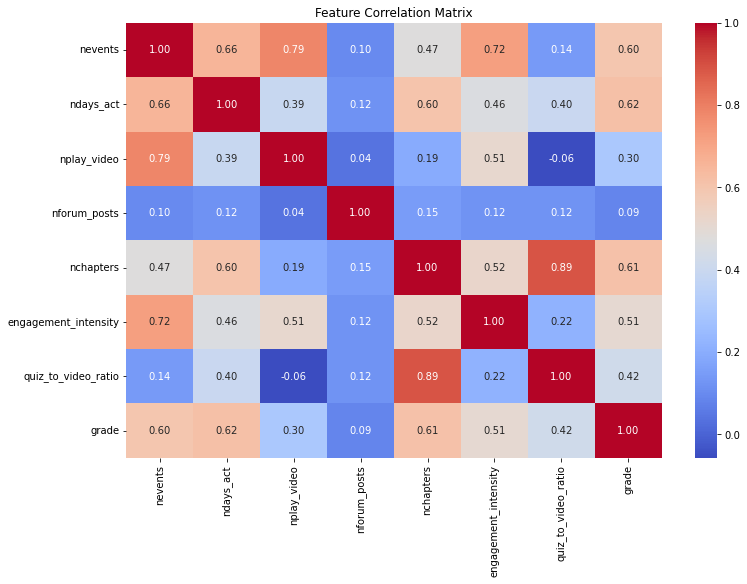

In [9]:
# ----------------------------
# Output Validation
# ----------------------------
# Correlation analysis (Reference: Romero & Ventura, 2010)

print("\nMissing values after handling:")
print(df[cols + ['engagement_intensity', 'quiz_to_video_ratio']].isnull().sum())

print("\nSample engineered features:")
print(df[['engagement_intensity', 'quiz_to_video_ratio', 'learning_duration']].head())

print("\nCorrelation matrix:")
#print(df[features_to_scale + ['grade']].corr())

corr_matrix = df[numeric_features + ['grade']].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

In [10]:
# --------------------------------------------------------
# 8. Map Course Timelines 
# --------------------------------------------------------
# Reference: Ho et al. (2014) - "HarvardX and MITx: The First Year of Open Online Courses"
# Define course timelines from the dataset description
course_timelines = {
    'HarvardX/CB22x/2013_Spring': ('2013-03-02', '2013-07-26'),
    'HarvardX/CS50x/2012': ('2012-10-15', '2013-04-15'),
    'HarvardX/ER22x/2013_Spring': ('2013-03-02', '2013-07-26'),
    'HarvardX/PH207x/2012_Fall': ('2012-10-15', '2013-01-30'),
    'HarvardX/PH278x/2013_Spring': ('2013-05-15', '2013-07-25')
}

# Convert to datetime
course_timelines = {
    course: (pd.to_datetime(start), pd.to_datetime(end)) 
    for course, (start, end) in course_timelines.items()
}

# Add to dataframe
df['course_start'] = df['course_id'].map(lambda x: course_timelines[x][0])
df['course_end'] = df['course_id'].map(lambda x: course_timelines[x][1])

# Calculate official course duration in weeks (Ho et al., 2014)
df['course_duration_weeks'] = ((df['course_end'] - df['course_start']).dt.days // 7) + 1

print(df.head(5))

        userid_DI                   course_id  registered  viewed  explored  \
0  MHxPC130442623  HarvardX/CB22x/2013_Spring           1       0         0   
1  MHxPC130275857  HarvardX/CB22x/2013_Spring           1       0         0   
2  MHxPC130539455  HarvardX/CB22x/2013_Spring           1       1         0   
3  MHxPC130088379  HarvardX/CB22x/2013_Spring           1       1         0   
4  MHxPC130024894  HarvardX/CB22x/2013_Spring           1       1         0   

   certified final_cc_cname_DI      LoE_DI  YoB gender  ...  nforum_posts  \
0          0     United States  Bachelor's  NaN      m  ...     -0.076049   
1          0     United States  Bachelor's  NaN      m  ...     -0.076049   
2          0            France  Bachelor's  NaN      m  ...     -0.076049   
3          0     United States  Bachelor's  NaN      m  ...     -0.076049   
4          0     United States  Bachelor's  NaN      m  ...     -0.076049   

  no_video_interaction no_activity  engagement_intensity  quiz

In [11]:
# ----------------------------
# 9. Focus on One Course
# ----------------------------
# Reference: Ho et al. (2014) - HarvardX and MITx MOOC study

# Choose the course to work with
course_id = 'HarvardX/CB22x/2013_Spring'  
course_cb22x = df[df['course_id'] == course_id].copy()

print("\nCourse Data Overview:")
print(course_cb22x.info())
print(course_cb22x.head(5))



Course Data Overview:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30002 entries, 0 to 30001
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   userid_DI              30002 non-null  object        
 1   course_id              30002 non-null  object        
 2   registered             30002 non-null  int64         
 3   viewed                 30002 non-null  int64         
 4   explored               30002 non-null  int64         
 5   certified              30002 non-null  int64         
 6   final_cc_cname_DI      30002 non-null  object        
 7   LoE_DI                 30002 non-null  object        
 8   YoB                    25536 non-null  float64       
 9   gender                 30002 non-null  object        
 10  grade                  30002 non-null  float64       
 11  start_time_DI          30002 non-null  datetime64[ns]
 12  last_event_DI          30002 non-null

In [12]:
# ----------------------------
# 10. Generate Weekly Time-Series Data
# ----------------------------
# Reference: Boroujeni & Dillenbourg (2019) - Temporal MOOC engagement

def generate_weekly_engagement(row):
    """
    Generate weekly time-series data for each learner.
    Each week is represented as a column, and engagement is tracked.
    """
    # Get the total number of weeks for the course
    total_weeks = row['course_duration_weeks']
    
    # Initialize weekly engagement dictionary
    weekly_dist = {f'week_{i+1}': 0 for i in range(total_weeks)}
    
    # Calculate the weeks between their start and end
    if pd.notnull(row['start_time_DI']) and pd.notnull(row['last_event_DI']):
        start_offset = max(0, (row['start_time_DI'] - row['course_start']).days // 7)
        end_offset = min(total_weeks - 1, (row['last_event_DI'] - row['course_start']).days // 7)
        
        # Mark weeks as active if within course duration
        for week_num in range(start_offset, end_offset + 1):
            weekly_dist[f'week_{week_num + 1}'] = row['nevents_raw'] / (end_offset - start_offset + 1)
    
    # Return as a series with float64
    return pd.Series(weekly_dist, dtype=np.float64)

# Apply the function to calculate weekly engagement
weekly_engagement = course_cb22x.apply(generate_weekly_engagement, axis=1)

# Fill NaNs with 0 for weeks where there was no engagement
weekly_engagement = weekly_engagement.fillna(0)

# Concatenate with the original dataframe
course_cb22x = pd.concat([course_cb22x, weekly_engagement], axis=1)

print("\nSample Weekly Engagement Data:")
print(course_cb22x[['userid_DI', 'course_id'] + [f'week_{i}' for i in range(1,6)]].head(5))



Sample Weekly Engagement Data:
        userid_DI                   course_id     week_1     week_2  \
0  MHxPC130442623  HarvardX/CB22x/2013_Spring   0.000000   0.000000   
1  MHxPC130275857  HarvardX/CB22x/2013_Spring   0.000000   0.000000   
2  MHxPC130539455  HarvardX/CB22x/2013_Spring   3.818182   3.818182   
3  MHxPC130088379  HarvardX/CB22x/2013_Spring  23.333333  23.333333   
4  MHxPC130024894  HarvardX/CB22x/2013_Spring   8.333333   8.333333   

      week_3    week_4    week_5  
0   0.000000  0.000000  0.000000  
1   0.000000  0.000000  0.000000  
2   3.818182  3.818182  3.818182  
3  23.333333  0.000000  0.000000  
4   8.333333  8.333333  8.333333  


In [13]:
# ----------------------------
# 11. Pre-Course and Post-Course Engagement
# ----------------------------
# Reference: Gardner & Brooks (2018) - MOOC engagement analysis

# Initialize columns for pre and post course engagement
course_cb22x['pre_course_engagement'] = 0
course_cb22x['post_course_engagement'] = 0
course_cb22x['pre_course_event_count'] = 0
course_cb22x['post_course_event_count'] = 0

# Loop through each row and calculate pre and post course events
for index, row in course_cb22x.iterrows():
    
    # Pre-Course Engagement
    if row['start_time_DI'] < row['course_start']:
        pre_duration = (row['course_start'] - row['start_time_DI']).days
        if pre_duration > 0:
            course_cb22x.at[index, 'pre_course_engagement'] = 1
            
            # Proportion of events before the course start
            if row['learning_duration'] > 0:
                course_cb22x.at[index, 'pre_course_event_count'] = row['nevents_raw'] * (pre_duration / row['learning_duration'])
            else:
                course_cb22x.at[index, 'pre_course_event_count'] = 0
            
    
    # Post-Course Engagement
    if row['last_event_DI'] > row['course_end']:
        post_duration = (row['last_event_DI'] - row['course_end']).days
        if post_duration > 0:
            course_cb22x.at[index, 'post_course_engagement'] = 1
            
            # Proportion of events after the course end
            if row['learning_duration'] > 0:
                course_cb22x.at[index, 'post_course_event_count'] = row['nevents_raw'] * (post_duration / row['learning_duration'])
            else:
                course_cb22x.at[index, 'post_course_event_count'] = 0
            

print("\nPre and Post-Course Engagement Data:")
print(course_cb22x[['userid_DI', 'course_id', 'pre_course_engagement', 'post_course_engagement', 
                   'pre_course_event_count', 'post_course_event_count']].head(5))



Pre and Post-Course Engagement Data:
        userid_DI                   course_id  pre_course_engagement  \
0  MHxPC130442623  HarvardX/CB22x/2013_Spring                      1   
1  MHxPC130275857  HarvardX/CB22x/2013_Spring                      1   
2  MHxPC130539455  HarvardX/CB22x/2013_Spring                      1   
3  MHxPC130088379  HarvardX/CB22x/2013_Spring                      1   
4  MHxPC130024894  HarvardX/CB22x/2013_Spring                      1   

   post_course_engagement  pre_course_event_count  post_course_event_count  
0                       1                       0                        0  
1                       1                       0                        0  
2                       0                      18                        0  
3                       0                      30                        0  
4                       1                      33                        7  


In [14]:
# ----------------------------
# 12. Row-Wise Z-Score Normalization
# ----------------------------
# Reference: Han et al. (2011) - Data preprocessing for clustering

# List all weekly columns
weekly_columns = [col for col in course_cb22x.columns if 'week_' in col]

def normalize_per_student(row):
    """
    Apply row-wise z-score normalization across weekly engagement.
    """
    mean_val = row[weekly_columns].mean()
    std_val = row[weekly_columns].std()
    
    # Create new columns for normalized data
    for week in weekly_columns:
        norm_col = f"{week}_norm"
        if std_val == 0 or np.isnan(std_val):
            row[norm_col] = 0
        else:
            row[norm_col] = (row[week] - mean_val) / std_val
    
    return row

# Apply normalization
course_cb22x = course_cb22x.apply(normalize_per_student, axis=1)


print("\nSample Weekly Engagement Data (Raw and Normalized):")
print(course_cb22x[['userid_DI', 'course_id'] + weekly_columns + [f'{w}_norm' for w in weekly_columns]].head(5))


Sample Weekly Engagement Data (Raw and Normalized):
        userid_DI                   course_id     week_1     week_2  \
0  MHxPC130442623  HarvardX/CB22x/2013_Spring   0.000000   0.000000   
1  MHxPC130275857  HarvardX/CB22x/2013_Spring   0.000000   0.000000   
2  MHxPC130539455  HarvardX/CB22x/2013_Spring   3.818182   3.818182   
3  MHxPC130088379  HarvardX/CB22x/2013_Spring  23.333333  23.333333   
4  MHxPC130024894  HarvardX/CB22x/2013_Spring   8.333333   8.333333   

      week_3    week_4    week_5    week_6    week_7    week_8  ...  \
0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  ...   
1   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  ...   
2   3.818182  3.818182  3.818182  3.818182  3.818182  3.818182  ...   
3  23.333333  0.000000  0.000000  0.000000  0.000000  0.000000  ...   
4   8.333333  8.333333  8.333333  8.333333  8.333333  8.333333  ...   

   week_12_norm  week_13_norm  week_14_norm  week_15_norm  week_16_norm  \
0      0.000000   

In [15]:
# ----------------------------
# 13. Phase Segmentation (Early, Mid, Late)
# ----------------------------
# Reference: Boroujeni & Dillenbourg (2019) - Course phase analysis

def assign_course_phase(total_weeks):
    """
    Divide the course duration into three phases:
    - Early: First 1/3 of the course weeks
    - Mid: Middle 1/3 of the course weeks
    - Late: Last 1/3 of the course weeks
    """
    # Calculate the phase ranges
    early_phase_end = total_weeks // 3
    mid_phase_end = (2 * total_weeks) // 3
    
    # Create a dictionary to map weeks to phases
    phase_mapping = {}
    for i in range(total_weeks):
        week_label = f'week_{i+1}'
        if i < early_phase_end:
            phase_mapping[week_label] = 'Early'
        elif i < mid_phase_end:
            phase_mapping[week_label] = 'Mid'
        else:
            phase_mapping[week_label] = 'Late'
    
    return phase_mapping

# Generate the mapping for the current course
total_weeks = course_cb22x['course_duration_weeks'].iloc[0]
print('Total weeks:')
print(total_weeks)
phase_mapping = assign_course_phase(total_weeks)

# Create a new column to store the phase information for each week
for week in phase_mapping:
    course_cb22x[f'{week}_phase'] = phase_mapping[week]


Total weeks:
21



Engagement Intensity per Phase:
{'Early': 1161473.1893052165, 'Mid': 857626.4804237344, 'Late': 1014960.3302710489}

Number of Active Learners per Phase:
{'Early': 50198, 'Mid': 28646, 'Late': 20501}


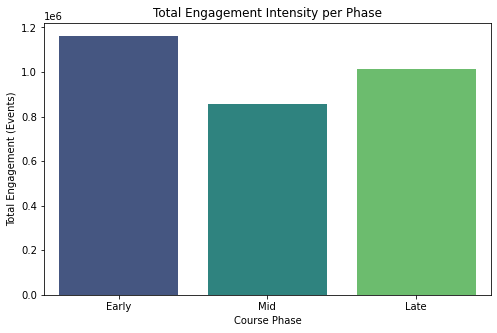

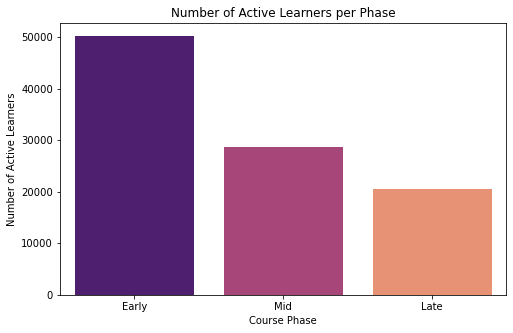

In [16]:
# ----------------------------
# 14. Visualize Engagement Intensity by Phase
# ----------------------------
# Reference: Wickham, H. (2016) - Data Visualization for Analysis

# Initialize the dictionary to store engagement sums for each phase
phase_intensity = {'Early': 0, 'Mid': 0, 'Late': 0}
phase_counts = {'Early': 0, 'Mid': 0, 'Late': 0}

# Loop through the weekly phase columns and sum total engagement
for week in range(1, total_weeks + 1):
    phase = phase_mapping[f'week_{week}']
    
    # Sum the raw weekly engagement for that phase
    total_engagement = course_cb22x[f'week_{week}'].sum()
    phase_intensity[phase] += total_engagement
    
    # Count the number of active learners
    active_learners = (course_cb22x[f'week_{week}'] > 0).sum()
    phase_counts[phase] += active_learners

# Display the results
print("\nEngagement Intensity per Phase:")
print(phase_intensity)

print("\nNumber of Active Learners per Phase:")
print(phase_counts)

# Plot the engagement intensity
plt.figure(figsize=(8, 5))
sns.barplot(x=list(phase_intensity.keys()), y=list(phase_intensity.values()), palette="viridis")
plt.title("Total Engagement Intensity per Phase")
plt.xlabel("Course Phase")
plt.ylabel("Total Engagement (Events)")
plt.show()

# Plot the number of active learners
plt.figure(figsize=(8, 5))
sns.barplot(x=list(phase_counts.keys()), y=list(phase_counts.values()), palette="magma")
plt.title("Number of Active Learners per Phase")
plt.xlabel("Course Phase")
plt.ylabel("Number of Active Learners")
plt.show()
